In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from geopy.distance import great_circle as vc
import math as Math

import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import math, time

from keras.models import model_from_json


Bad key "text.kerning_factor" on line 4 in
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
data = pd.read_csv('filter_data.csv', index_col=None)
data['unique-key'] = data['Name'] + '-' + data['year'].map(str)
data.drop(['Name', 'year'], axis = 1, inplace = True)
data.head()

,month,day,Date,Class,Lat,Lon,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,unique-key
0,6,2,1200,TD,21.7,87.1,20,1005,27.51,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982
1,6,2,1800,TD,22.2,86.5,25,1004,28.15,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982
2,6,3,0,TD,22.6,85.8,30,1003,27.47,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982
3,6,3,600,TS,22.8,85.0,40,1001,27.00,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982
4,6,3,1200,TS,23.2,84.2,50,995,26.99,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982


In [3]:
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

482


In [4]:
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of data quantity)
             NADINE-2012 - 96.0
               KYLE-2002 - 90.0
             LESLIE-2018 - 86.0
               JOSE-2017 - 81.0
            MARILYN-1995 - 79.0
           FLORENCE-2018 - 79.0


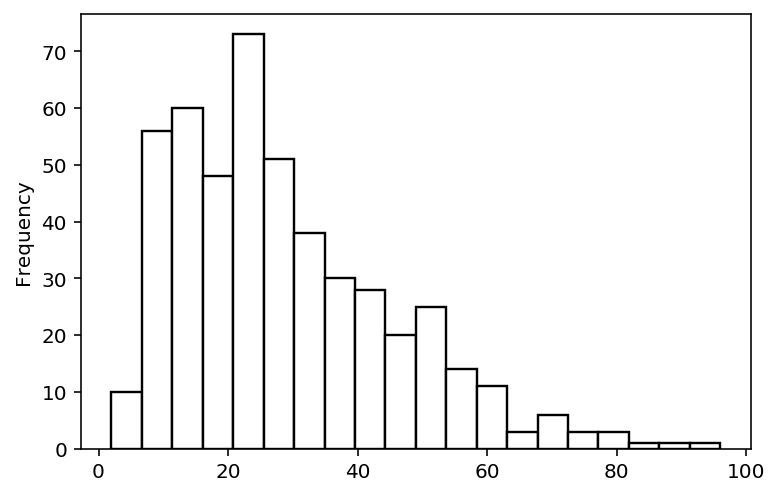

In [5]:
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.show()

In [6]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)
total_data_count = len(data)

482


In [7]:
data.to_csv('data_for_preprocessing.csv')

In [8]:
data = pd.read_csv('data_for_preprocessing.csv', index_col=0, header=0)
data.head()

,month,day,Date,Class,Lat,Lon,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,unique-key
0,6,2,1200,TD,21.7,87.1,20,1005,27.51,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982
1,6,2,1800,TD,22.2,86.5,25,1004,28.15,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982
2,6,3,0,TD,22.6,85.8,30,1003,27.47,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982
3,6,3,600,TS,22.8,85.0,40,1001,27.00,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982
4,6,3,1200,TS,23.2,84.2,50,995,26.99,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982


In [9]:
y = np.zeros(total_hurricane_count)
data['distance'] = np.zeros(total_data_count)
data['direction'] = np.zeros(total_data_count)

# For all hurricanes
for x in range(0, total_hurricane_count):
    t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    
    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['Lat'], t['Lon']):
        
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        data.at[t[(t['Lat'] == p[0]) & (t['Lon'] == p[1])]['index'].values[0], 'distance'] = vc(prev,p).miles
        
        dLon = p[1] - prev[1];  
        temp = float(p[0]) # p[0] is a str?
        y_x = Math.sin(dLon) * Math.cos(temp);
        
        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        data.at[t[(t['Lat'] == p[0]) & (t['Lon'] == p[1])]['index'].values[0], 'direction'] = brng
        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
hurricane_distance = pd.DataFrame(y)

In [10]:
data.to_csv('data_with_DandD.csv')
data = pd.read_csv('data_with_DandD.csv', index_col=0, header=0)
data.head()

,month,day,Date,Class,Lat,Lon,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,unique-key,distance,direction
0,6,2,1200,TD,21.7,87.1,20,1005,27.51,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982,0.000000,0.000000
1,6,2,1800,TD,22.2,86.5,25,1004,28.15,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982,51.690741,146.190548
2,6,3,0,TD,22.6,85.8,30,1003,27.47,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,52.567404,110.730336
3,6,3,600,TS,22.8,85.0,40,1001,27.00,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,52.832158,38.279615
4,6,3,1200,TS,23.2,84.2,50,995,26.99,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,57.902016,15.703606


In [11]:
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of distance traveled)
            EDOUARD-1984 - 6630.135380137772 miles - 28.0
             NADINE-2012 - 5957.013203288032 miles - 96.0
               IVAN-2004 - 5847.192692220913 miles - 77.0
             LESLIE-2018 - 5816.79675982043 miles - 86.0
            ALBERTO-2000 - 5789.429363486013 miles - 74.0
            EDOUARD-1996 - 5675.213368831527 miles - 69.0


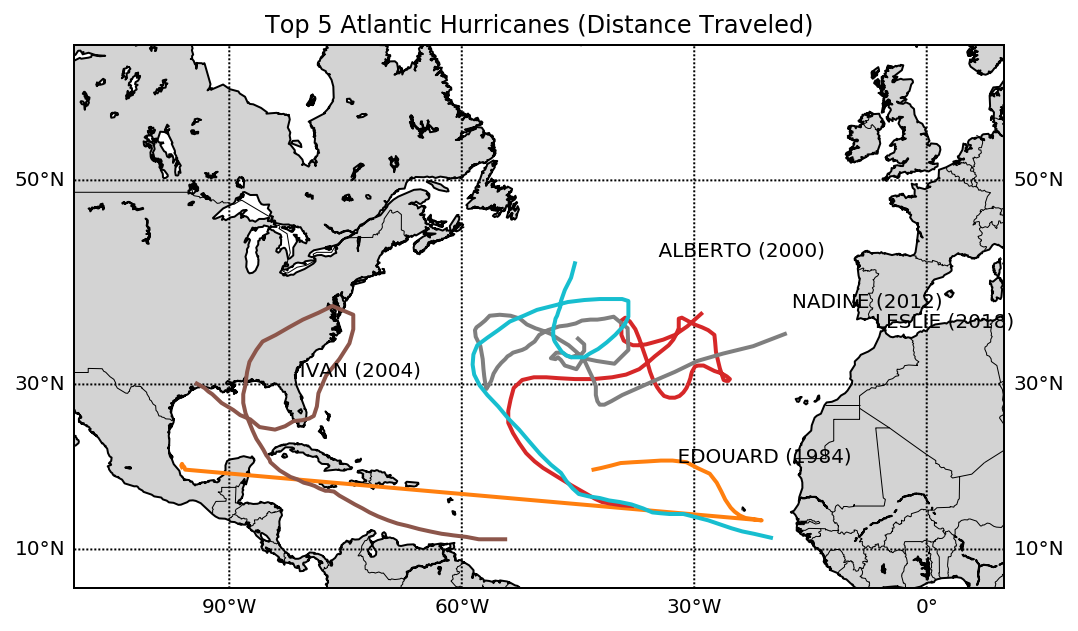

In [18]:
n = 5 # Number of hurricanes

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_distance.nlargest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    lon = largest_hurr['Lon'].values
    lon = [x * -1 for x in lon]
    xpt, ypt = m(lon, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(lon) - 1]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(5,5, linewidth=10)
    m.plot(xpt, ypt, linewidth=2)
    
plt.title('Top 5 Atlantic Hurricanes (Distance Traveled)')
plt.savefig('largest_dist_hurricanes')
plt.show()

In [19]:
import scipy

dist = data[data['distance'] > 0]['distance']
scipy.stats.anderson(dist, dist='norm')

AndersonResult(statistic=851.9620120562158, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

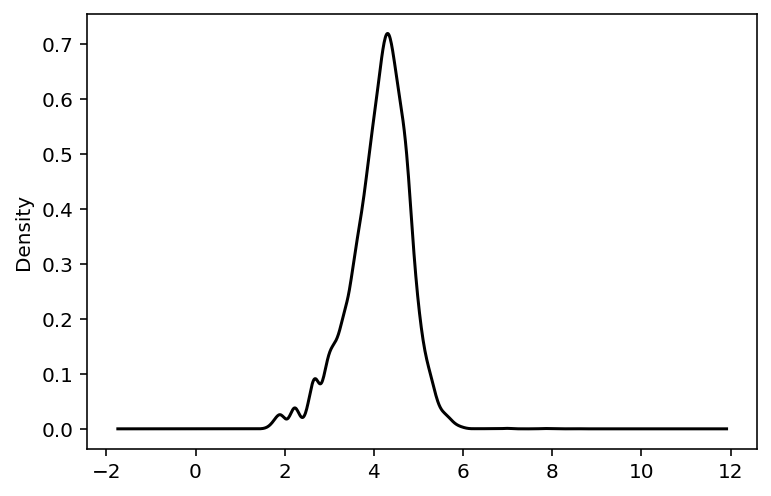

In [20]:
# Distribution of distance traveled in a 6 hour time interval for all hurricanes
dist = np.log(dist)
ser = pd.Series(dist)
ser.plot(kind='kde', cmap='gray')

In [21]:
dist_norm = normalized = (dist-min(dist))/(max(dist)-min(dist))
scipy.stats.anderson(dist_norm, dist='norm')

AndersonResult(statistic=101.60656114831363, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

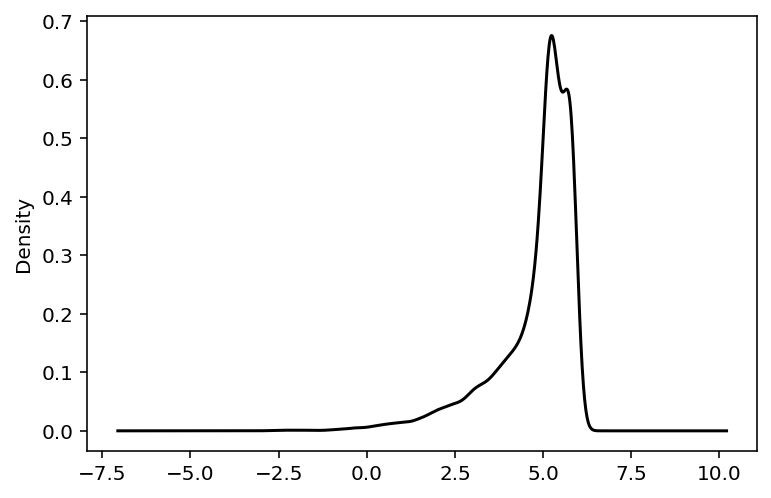

In [22]:
# Distribution of angle traveled in a 6 hour time interval for all hurricanes
direc = data[data['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot(kind='kde', cmap='gray')

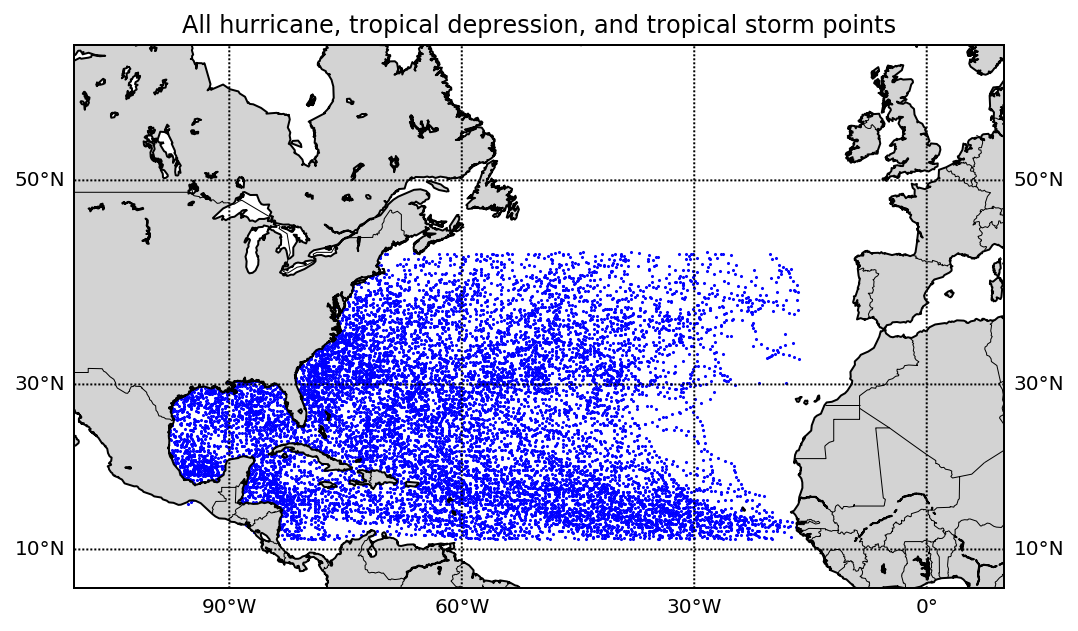

In [23]:
# Graph all points 
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = data['Lat'].values
lon = data['Lon'].values
lon = [x * -1 for x in lon]
xpt, ypt = m(lon, lat)
m.scatter(xpt, ypt, .3, color='blue')
plt.title('All hurricane, tropical depression, and tropical storm points')
plt.show()

In [24]:
lat_min = 7.2
lon_min = -109.3
lat_interval = round(66 - 7.2)
lon_interval = round(13.5 + 109.3)

grid_map = {}

data['gridID'] = np.floor(data['Lat'] - 7.200)* lon_interval  + np.floor(data['Lon'] + 109.3)
data['gridID'] = round(data['gridID'])

In [25]:
data.to_csv('points_with_gridIds.csv')

In [26]:
data.head()

,month,day,Date,Class,Lat,Lon,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,unique-key,distance,direction,gridID
0,6,2,1200,TD,21.7,87.1,20,1005,27.51,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982,0.000000,0.000000,1918.0
1,6,2,1800,TD,22.2,86.5,25,1004,28.15,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982,51.690741,146.190548,2040.0
2,6,3,0,TD,22.6,85.8,30,1003,27.47,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,52.567404,110.730336,2040.0
3,6,3,600,TS,22.8,85.0,40,1001,27.00,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,52.832158,38.279615,2039.0
4,6,3,1200,TS,23.2,84.2,50,995,26.99,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,57.902016,15.703606,2161.0


In [28]:
data = pd.read_csv('points_with_gridIds.csv', index_col=0, header=0)

In [29]:
names = data['unique-key'].unique()
data.drop(['month', 'day', 'Date', 'Lat', 'Lon', 'Class'], axis = 1, inplace = True)
data.head()

,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,unique-key,distance,direction,gridID
0,20,1005,27.51,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982,0.000000,0.000000,1918.0
1,25,1004,28.15,-4.149994,1.580002,78.380005,300.080017,ALBERTO-1982,51.690741,146.190548,2040.0
2,30,1003,27.47,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,52.567404,110.730336,2040.0
3,40,1001,27.00,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,52.832158,38.279615,2039.0
4,50,995,26.99,-1.160004,7.429993,82.729996,300.399994,ALBERTO-1982,57.902016,15.703606,2161.0


In [30]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['Max wind', 'Min pres', 'SST', 'UWND', 'VWND', 'rhum', 'airtemp', 'distance', 'direction', 'gridID']]]

In [31]:
data_pad[0:3]

[     Max wind  Min pres        SST      UWND      VWND       rhum     airtemp  \
 459        30      1011  27.260000 -7.059998 -6.949997  87.500000  301.369995   
 460        30      1011  26.310000 -1.059998  7.119995  91.690002  300.190002   
 461        30      1011  26.230000 -1.059998  7.119995  91.690002  300.190002   
 462        30      1010  26.279999 -1.059998  7.119995  91.690002  300.190002   
 463        35      1009  26.320000 -6.910004  2.479996  76.100006  298.070007   
 464        35      1009  25.840000  4.179993  1.229996  88.250000  296.910004   
 465        40      1008  25.670000  4.179993  1.229996  88.250000  296.910004   
 466        40      1007  25.939999 -6.610001  2.729996  85.720001  296.209992   
 467        45      1006  25.900000 -6.610001  2.729996  85.720001  296.209992   
 468        45      1004  26.580000  1.569992 -4.460007  88.110001  298.349976   
 469        45      1004  25.420000 -5.059998  2.860001  82.600006  298.489990   
 470        50  

In [32]:
len_vals = []
for x in range(len(data_pad)):
    len_vals += [len(data_pad[x])]
print(max(len_vals))

96


In [33]:
import sklearn
import keras 
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='int32', padding='post', truncating='pre', value=0.0)

In [35]:
padded_data[3]

array([[  30, 1008,   21,   -1,    8,   84,  295,    0,    0, 2758],
       [  30, 1008,   21,   -1,    8,   84,  295,   56,  359, 2881],
       [  30, 1008,   20,   -1,    8,   84,  295,   63,  339, 3004],
       [  30, 1007,   20,  -16,   -7,   80,  292,   81,  114, 3127],
       [  30, 1007,   20,    3,    5,   89,  292,   83,  180, 3251],
       [  35, 1006,   21,  -17,    0,   80,  292,   68,  222, 3374],
       [  35, 1006,   20,  -17,    0,   80,  292,   74,  255, 3498],
       [  35, 1006,   20,  -16,  -15,   76,  292,   31,  297, 3499],
       [  40, 1005,   20,    1,  -16,   80,  293,   48,    4, 3376],
       [  40, 1003,   20,    1,  -16,   80,  293,   62,  358, 3253],
       [  45, 1000,   20,    0,    5,   85,  293,   63,  327, 3129],
       [  45,  998,   20,    0,    5,   85,  293,   56,  304, 3128],
       [  50,  995,   20,   -6,  -12,   78,  293,   56,  289, 3127],
       [  50,  995,   20,    9,    1,   80,  294,   65,  328, 3004],
       [  50,  995,   21,    9,   

In [36]:
scalers = {}
gridScalers = {}
for name in names:
    scalers[name] = MinMaxScaler(feature_range=(0, 1))
#     gridScalers[name] = MinMaxScaler(feature_range=(0, 1))
#     gridScalers[name].fit_transform((data[data['unique-key'] == name])['gridID'].reshape(-1,1))
    hurricane = data[data['unique-key'] == name]
    hurricane.drop('unique-key', axis = 1, inplace= True)
    
    hurricane = pd.DataFrame(scalers[name].fit_transform(hurricane), columns=['Max wind', 
                                                                              'Min pres', 
                                                                              'SST', 
                                                                              'UWND', 
                                                                              'VWND', 
                                                                              'rhum', 
                                                                              'airtemp', 
                                                                              'distance', 
                                                                              'direction', 
                                                                              'gridID'])
    data.loc[data['unique-key'] == name, ['Max wind', 'Min pres', 'SST', 'UWND', 'VWND', 'rhum', 'airtemp', 'distance', 'direction', 'gridID']] = hurricane.values

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/david/anaconda/lib

In [37]:
data.head()

,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,unique-key,distance,direction,gridID
0,0.000000,0.80,0.774648,0.000000,0.118082,0.097778,0.421064,ALBERTO-1982,0.000000,0.000000,0.000000
1,0.090909,0.76,1.000000,0.000000,0.118082,0.097778,0.421064,ALBERTO-1982,0.770697,0.551430,0.249489
2,0.181818,0.72,0.760563,0.429597,0.837638,0.742221,0.589473,ALBERTO-1982,0.783767,0.417675,0.249489
3,0.363636,0.64,0.595070,0.429597,0.837638,0.742221,0.589473,ALBERTO-1982,0.787715,0.144391,0.247444
4,0.545455,0.40,0.591549,0.429597,0.837638,0.742221,0.589473,ALBERTO-1982,0.863305,0.059234,0.496933


In [38]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['Max wind', 'Min pres', 'SST', 'UWND', 'VWND', 'rhum', 'airtemp', 'distance', 'direction', 'gridID']]]

In [39]:
data_pad[1]

,Max wind,Min pres,SST,UWND,VWND,rhum,airtemp,distance,direction,gridID
2121,0.0,1.000000,0.969309,0.104043,0.268105,0.175658,0.649262,0.000000,0.000000,0.000000
2122,0.0,1.000000,0.968297,0.120690,0.070878,0.000000,0.869491,0.314303,0.353942,0.000684
2123,0.0,1.000000,0.945363,0.225921,0.420647,0.489474,0.815660,0.314303,0.175912,0.001367
2124,0.0,1.000000,0.000000,0.225921,0.420647,0.489474,0.815660,0.284903,0.088297,0.002051
2125,0.0,1.000000,0.983811,0.247324,0.182589,0.586842,0.786297,0.290909,0.068164,0.086808
2126,0.0,1.000000,0.983137,0.184304,0.157935,0.800000,0.621533,0.256415,0.000426,0.086808
2127,0.0,1.000000,0.989882,0.339476,0.325115,0.519738,0.570962,0.229501,0.977246,0.171565
2128,0.0,1.000000,1.000000,0.339476,0.325115,0.519738,0.570962,0.244579,0.000000,0.171565
2129,0.0,1.000000,0.000000,0.339476,0.325115,0.519738,0.570962,0.252192,0.072941,0.254956
2130,0.0,1.000000,0.000000,0.000000,0.305085,0.388159,0.644373,0.228808,0.455470,0.339029


In [40]:
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='float', padding='post', truncating='pre', value=0.0)

In [41]:
padded_data[0]

array([[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.31237753e-01, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 9.09867173e-01, 5.33808293e-01,
        8.87136918e-01, 1.00000000e+00, 7.71319404e-01, 3.30766369e-01,
        1.00000000e+00, 6.25782228e-04],
       [0.00000000e+00, 1.00000000e+00, 9.02277040e-01, 5.33808293e-01,
        8.87136918e-01, 1.00000000e+00, 7.71319404e-01, 3.19716667e-01,
        3.00051816e-02, 6.25782228e-04],
       [0.00000000e+00, 9.33333333e-01, 9.07020778e-01, 5.33808293e-01,
        8.87136918e-01, 1.00000000e+00, 7.71319404e-01, 3.50718389e-01,
        7.40817298e-02, 7.82227785e-02],
       [2.00000000e-01, 8.66666667e-01, 9.10815939e-01, 1.33446644e-02,
        5.94577069e-01, 0.00000000e+00, 3.60467927e-01, 3.99987709e-01,
        1.08966904e-01, 1.55193992e-01],
       [2.00000000e-01, 8.66666667e-01, 8.65275142e-01, 1.00000000e+00,
   

In [42]:
print(len(padded_data[0]))
print(len(padded_data))

60
482


In [43]:
temp_flat = padded_data.reshape(60*482,10)

In [44]:
def load_data(stock, seq_len, amount_of_features):
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(stock) - sequence_length):
        seq = stock[index: index + sequence_length]
        result.append(seq)
    
    result = np.array(result)
    row = len(result) * 0.85 # Amount of data to train on    
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [45]:
def build_model(layers):
    model = Sequential()

    for x in range(0,3):
        model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
        model.add(Dropout(0.1))

    model.add(LSTM(layers[2], return_sequences=False)) 
    model.add(Dropout(0.1))

    model.add(Dense(output_dim=layers[2]))
    model.add(Activation("tanh"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [47]:
seq_len = 12 # Another hyperparameter- length of hurricane?
feature_count = 10
X_train, y_train, X_test, y_test = load_data(temp_flat[::-1], seq_len, feature_count)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (24570, 12, 10)
y_train (24570,)
X_test (4337, 12, 10)
y_test (4337,)


In [48]:
model = build_model([feature_count, seq_len, 1])

/Users/david/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/david/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 10), units=12)`
  """


Compilation Time :  0.018580913543701172


/Users/david/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # This is added back by InteractiveShellApp.init_path()


In [49]:
model.fit(X_train, y_train, batch_size=512, epochs=200, validation_split=0.1, verbose=1)

Train on 22113 samples, validate on 2457 samples
Epoch 1/200
22113/22113 [==============================] - 3s 141us/step - loss: 0.0999 - accuracy: 0.5512 - val_loss: 0.0787 - val_accuracy: 0.5039
Epoch 2/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0796 - accuracy: 0.5498 - val_loss: 0.0685 - val_accuracy: 0.5059
Epoch 3/200
22113/22113 [==============================] - 1s 63us/step - loss: 0.0706 - accuracy: 0.5497 - val_loss: 0.0593 - val_accuracy: 0.5067
Epoch 4/200
22113/22113 [==============================] - 1s 64us/step - loss: 0.0618 - accuracy: 0.5493 - val_loss: 0.0558 - val_accuracy: 0.5063
Epoch 5/200
22113/22113 [==============================] - 1s 64us/step - loss: 0.0564 - accuracy: 0.5504 - val_loss: 0.0470 - val_accuracy: 0.5063
Epoch 6/200
22113/22113 [==============================] - 1s 66us/step - loss: 0.0500 - accuracy: 0.5524 - val_loss: 0.0390 - val_accuracy: 0.5059
Epoch 7/200
22113/22113 [==============================] - 2s 

Epoch 56/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0272 - accuracy: 0.5575 - val_loss: 0.0189 - val_accuracy: 0.5096
Epoch 57/200
22113/22113 [==============================] - 1s 64us/step - loss: 0.0268 - accuracy: 0.5573 - val_loss: 0.0194 - val_accuracy: 0.5096
Epoch 58/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0266 - accuracy: 0.5572 - val_loss: 0.0181 - val_accuracy: 0.5096
Epoch 59/200
22113/22113 [==============================] - 1s 63us/step - loss: 0.0265 - accuracy: 0.5570 - val_loss: 0.0194 - val_accuracy: 0.5096
Epoch 60/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0271 - accuracy: 0.5569 - val_loss: 0.0182 - val_accuracy: 0.5096
Epoch 61/200
22113/22113 [==============================] - 1s 61us/step - loss: 0.0268 - accuracy: 0.5574 - val_loss: 0.0189 - val_accuracy: 0.5096
Epoch 62/200
22113/22113 [==============================] - 1s 61us/step - loss: 0.0265 - accuracy: 0.5574

Epoch 111/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0259 - accuracy: 0.5576 - val_loss: 0.0184 - val_accuracy: 0.5096
Epoch 112/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0261 - accuracy: 0.5577 - val_loss: 0.0182 - val_accuracy: 0.5100
Epoch 113/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0264 - accuracy: 0.5575 - val_loss: 0.0180 - val_accuracy: 0.5100
Epoch 114/200
22113/22113 [==============================] - 2s 74us/step - loss: 0.0266 - accuracy: 0.5573 - val_loss: 0.0182 - val_accuracy: 0.5100
Epoch 115/200
22113/22113 [==============================] - 2s 75us/step - loss: 0.0263 - accuracy: 0.5577 - val_loss: 0.0180 - val_accuracy: 0.5100
Epoch 116/200
22113/22113 [==============================] - 2s 71us/step - loss: 0.0262 - accuracy: 0.5575 - val_loss: 0.0184 - val_accuracy: 0.5100
Epoch 117/200
22113/22113 [==============================] - 1s 61us/step - loss: 0.0259 - accuracy:

22113/22113 [==============================] - 1s 62us/step - loss: 0.0261 - accuracy: 0.5578 - val_loss: 0.0176 - val_accuracy: 0.5100
Epoch 166/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0257 - accuracy: 0.5584 - val_loss: 0.0181 - val_accuracy: 0.5100
Epoch 167/200
22113/22113 [==============================] - 1s 61us/step - loss: 0.0261 - accuracy: 0.5581 - val_loss: 0.0176 - val_accuracy: 0.5100
Epoch 168/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0258 - accuracy: 0.5580 - val_loss: 0.0179 - val_accuracy: 0.5100
Epoch 169/200
22113/22113 [==============================] - 1s 62us/step - loss: 0.0259 - accuracy: 0.5578 - val_loss: 0.0176 - val_accuracy: 0.5100
Epoch 170/200
22113/22113 [==============================] - 1s 61us/step - loss: 0.0265 - accuracy: 0.5576 - val_loss: 0.0183 - val_accuracy: 0.5100
Epoch 171/200
22113/22113 [==============================] - 1s 61us/step - loss: 0.0256 - accuracy: 0.5580 - val_

In [50]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.0172 MSE (0.1313 RMSE)
Test Score: 0.0179 MSE (0.1338 RMSE)


In [51]:
# Serialize model to JSON
model_json = model.to_json()
with open("model_sheils.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model_sheils.h5")
print("Saved Model to Disk")

Saved Model to Disk


In [52]:
# Load json and create model
json_file = open('model_sheils.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("model_sheils.h5")
print("Loaded Model from Disk")
model = loaded_model

Loaded Model from Disk


In [53]:
pred = model.predict(X_test)

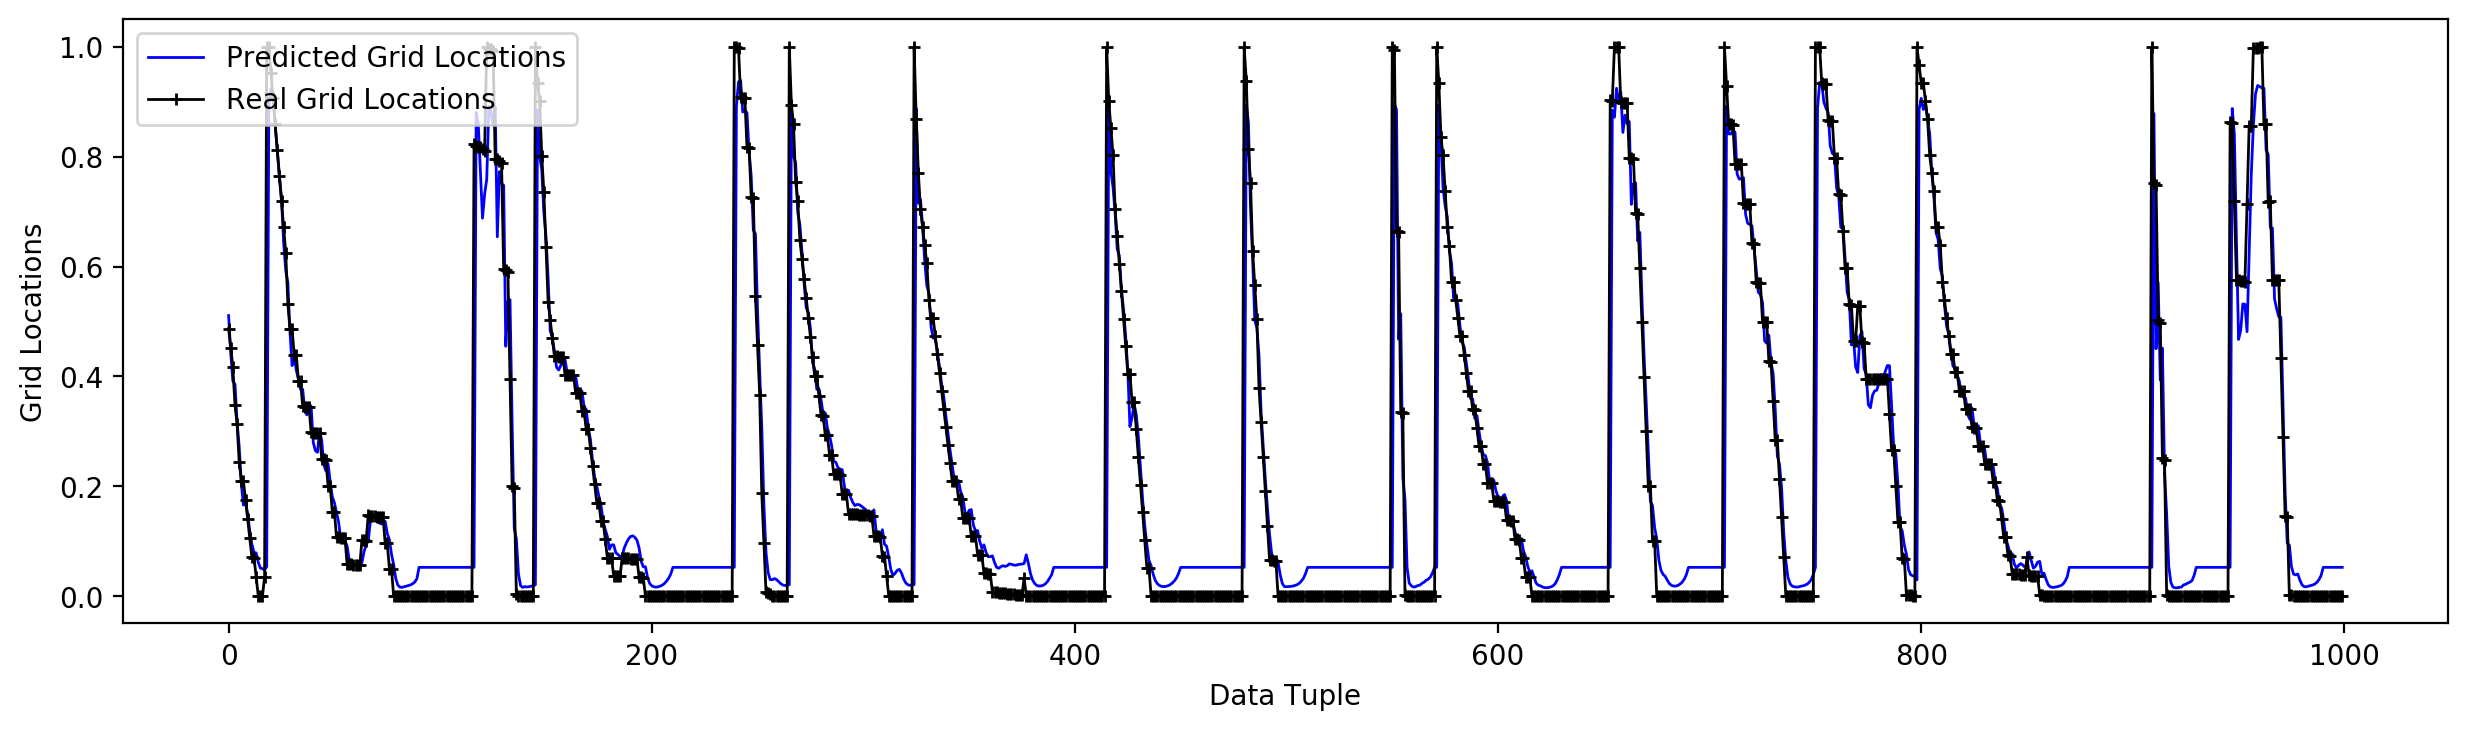

In [54]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:1000],
         linewidth=1, 
         color='blue', 
         label='Predicted Grid Locations')
plt.plot(y_test[:1000],
         linewidth=1, 
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
plt.show()

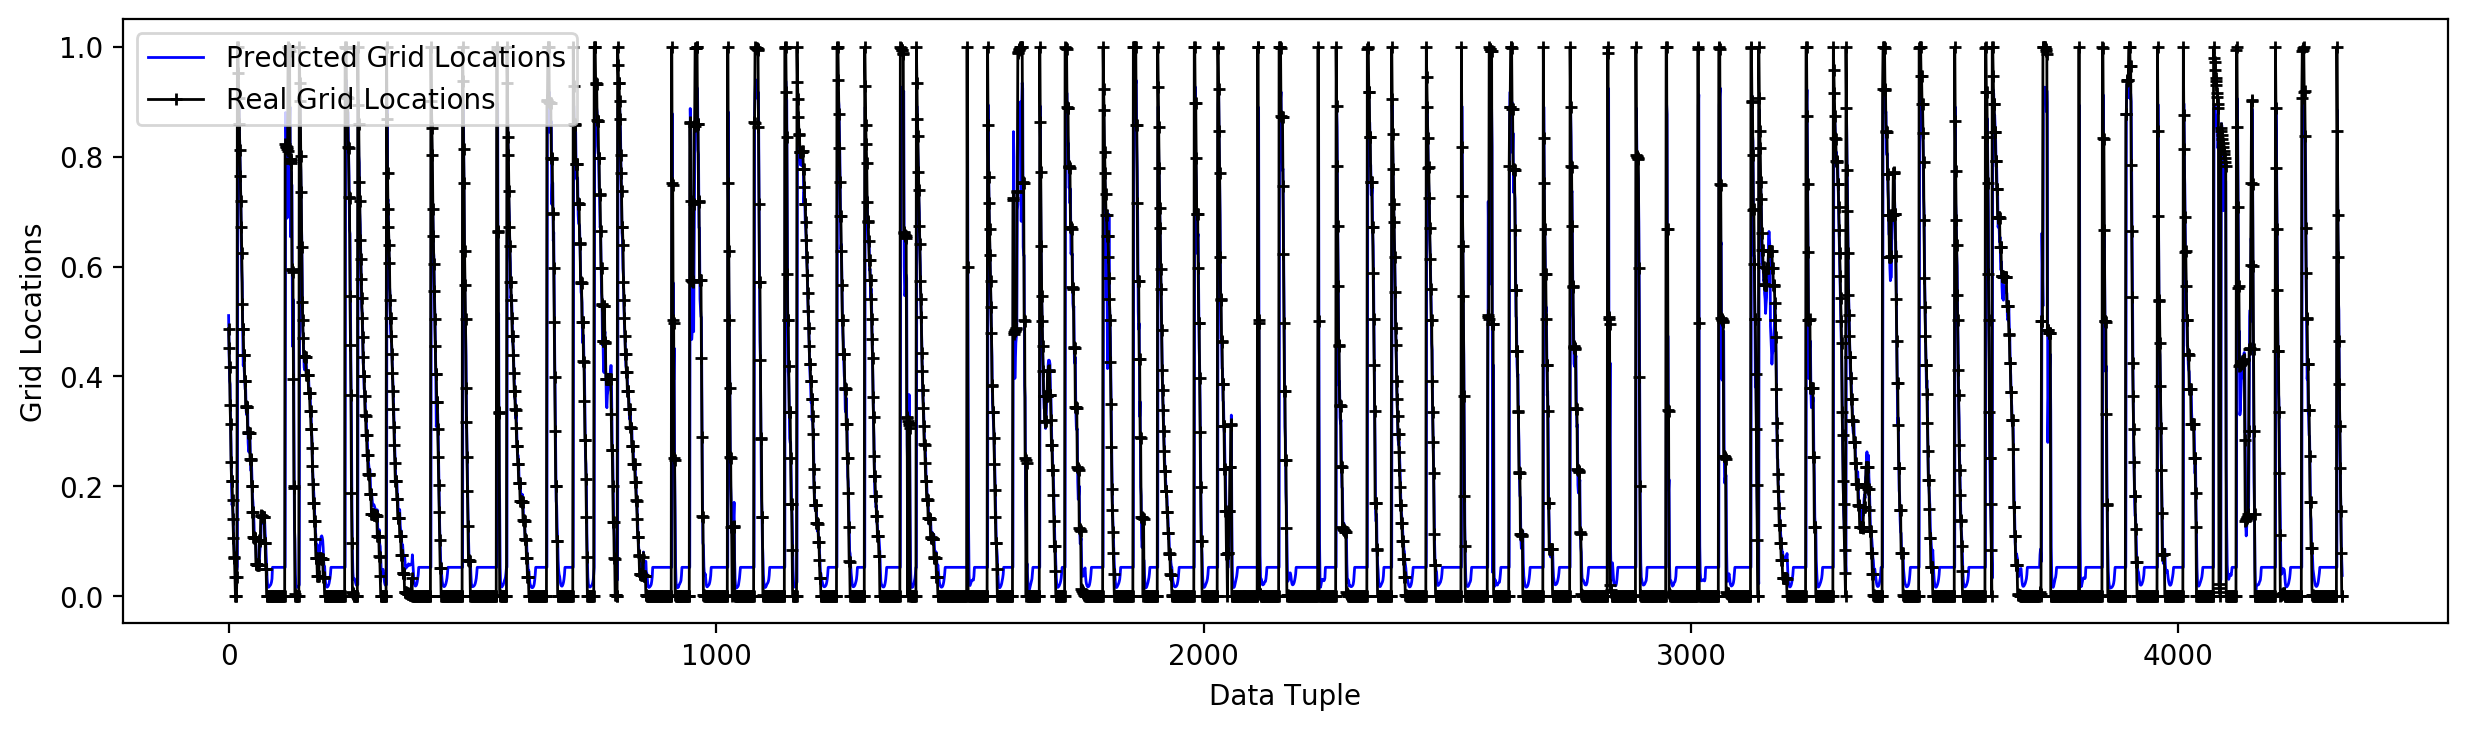

In [56]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred,
         linewidth=1, 
         color='blue', 
         label='Predicted Grid Locations')
plt.plot(y_test,
         linewidth=1, 
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
plt.show()

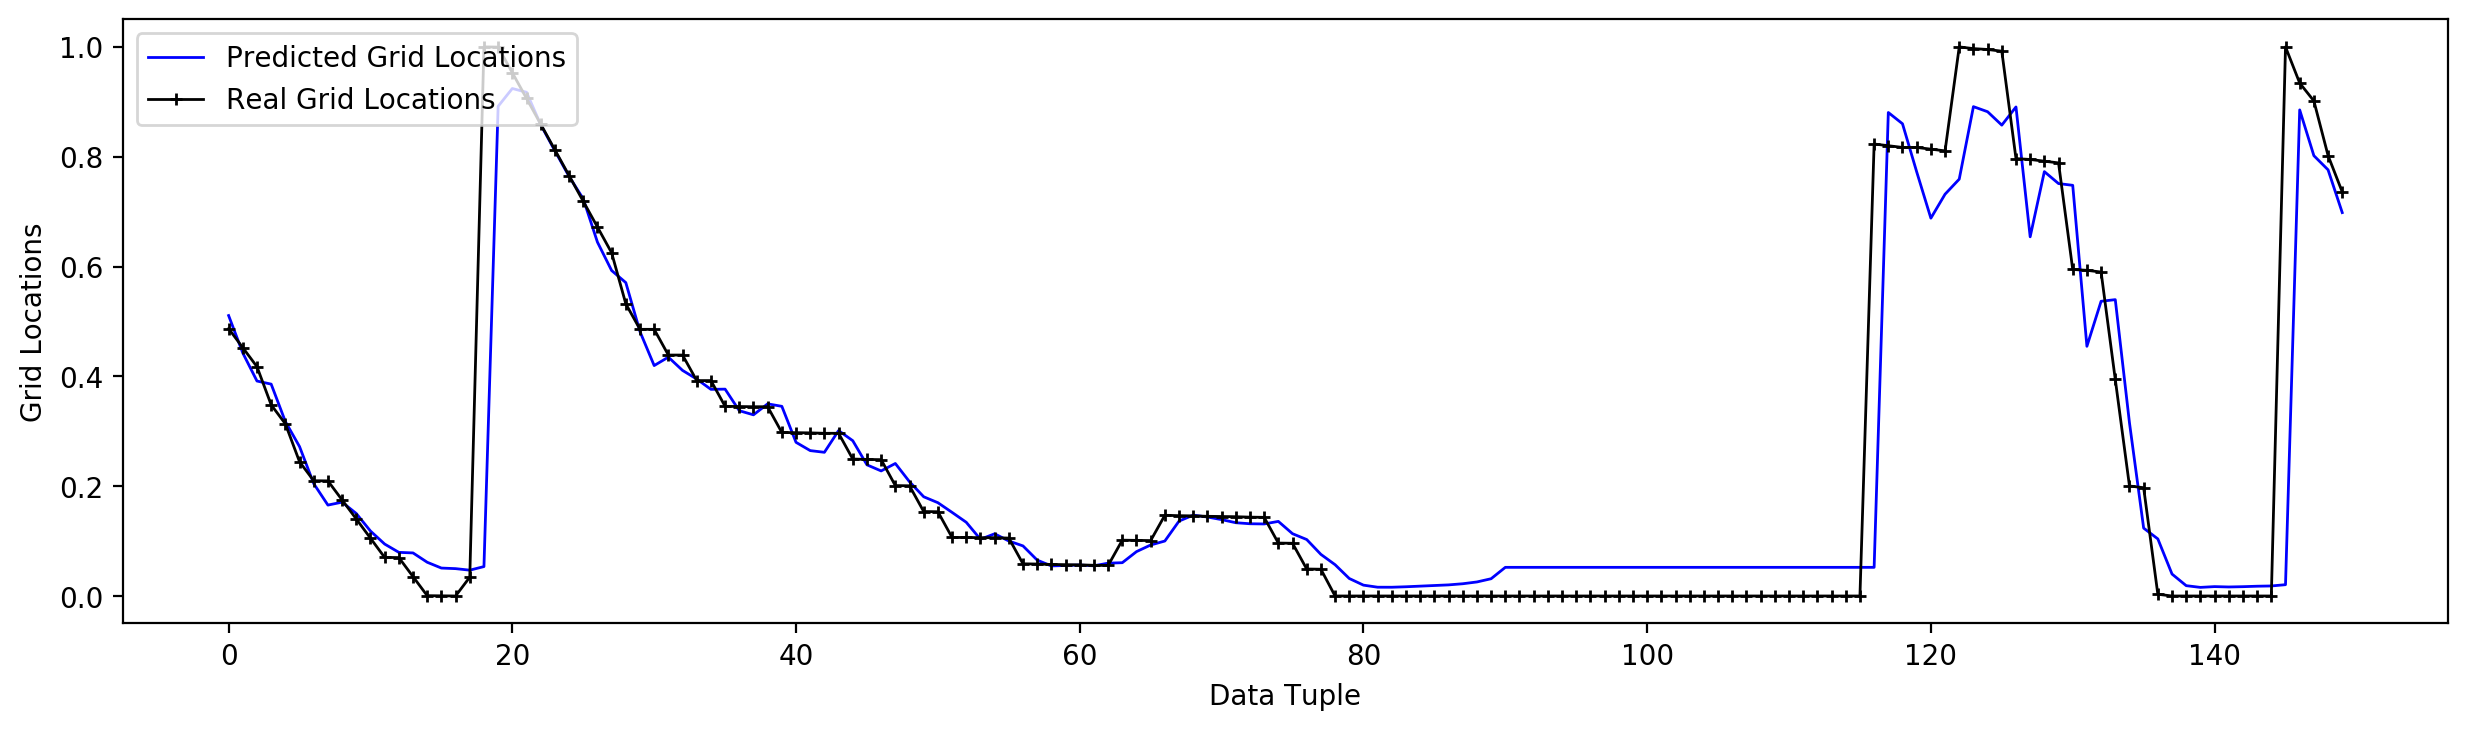

In [57]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:150],
         linewidth=1, 
         color='blue', 
         label='Predicted Grid Locations')
plt.plot(y_test[:150],
         linewidth=1, 
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
plt.show()

In [58]:
flat_pred = pred.flatten()

In [59]:
hurr_real = []
hurr_pred = []
temp_real = []
temp_pred = []
for x in range(len(y_test)):
    if not y_test[x] == 0:
        temp_real += [y_test[x]]
        temp_pred += [flat_pred[x]]
    else:
        hurr_real += [temp_real]
        hurr_pred += [temp_pred]
        temp_real = []
        temp_pred = []

In [60]:
print(len(hurr_real))
print(len(hurr_pred))

lol_real = [x for x in hurr_real if bool(x)]
print(len(lol_real))
lol_pred = [x for x in hurr_pred if bool(x)]
print(len(lol_pred))

2485
2485
82
82


In [68]:
from sklearn.preprocessing import MinMaxScaler

def load_hurricane(stock, seq_len):#load a single hurricane
    amount_of_features = len(stock.columns)
    data = stock.to_numpy()
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(data) - sequence_length):
        seq = data[index: index + sequence_length]
        result.append(seq)
                
    result = np.array(result)
    result = result[:,:-1]
    return np.reshape(result, (result.shape[0], result.shape[1], amount_of_features))

def prep_hurricane(hurr, name):
    data_pad = [hurr[ hurr.loc[:, 'unique-key'] == name].loc[:, ['Max wind', 'Min pres', 'SST', 'UWND', 'VWND', 'rhum', 'airtemp', 'distance', 'direction', 'gridID']]]
    hurr.drop(['month', 'day', 'Date', 'Lat', 'Lon', 'Class', 'unique-key'], axis = 1, inplace = True)
    hurr = hurr[hurr['distance'] > 0]

    hurr['distance'] = np.log(hurr['distance'])

    hurr = hurr[hurr['direction'] > 0]
    hurr['direction'] = np.log(hurr['direction'])
    
    padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=60, dtype='int32', padding='post', truncating='pre', value=0.0)
    
    return pd.DataFrame(scalers[name].fit_transform(padded_data[0]), columns=['Max wind', 'Min pres', 'SST', 'UWND', 'VWND', 'rhum', 'airtemp', 'distance', 'direction', 'gridID'])
    
def test():
    data = pd.read_csv('points_with_gridIds.csv', index_col=0, header=0)
    name = 'MICHAEL-2000' # Hurricane Key

    window = 5
    hurricane = prep_hurricane(data[data['unique-key'] == name], name) # This is good

    hurr_data = load_hurricane(hurricane[::-1], window)
    return hurr_data.shape

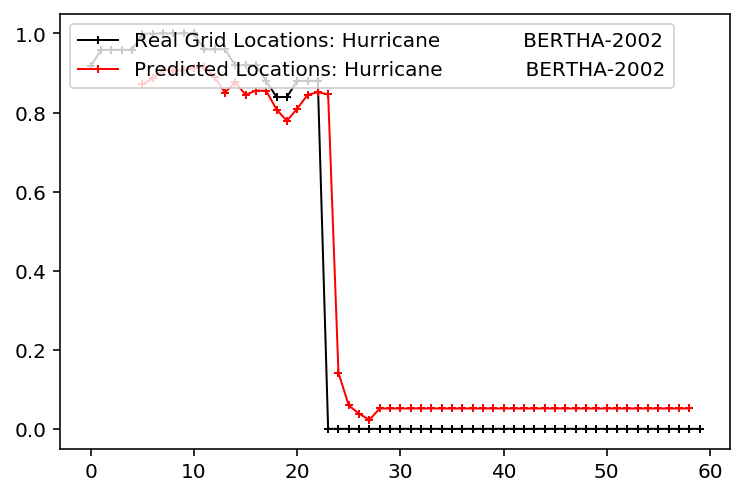

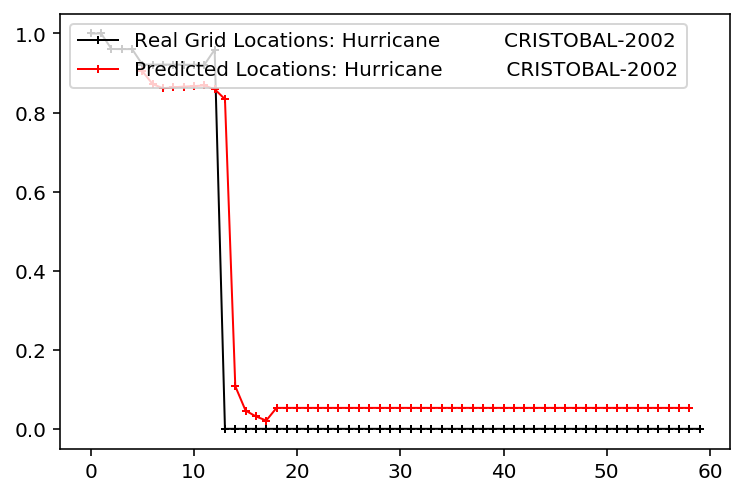

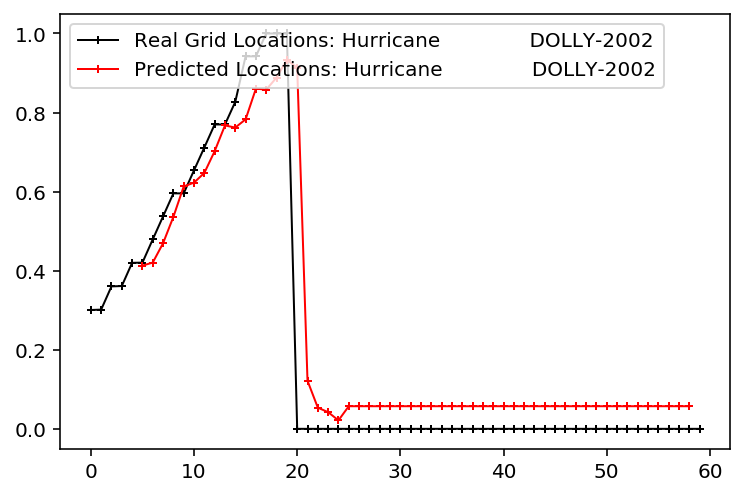

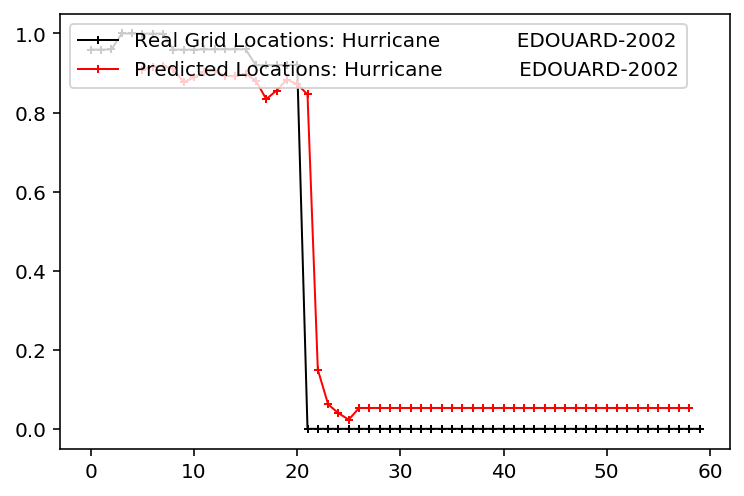

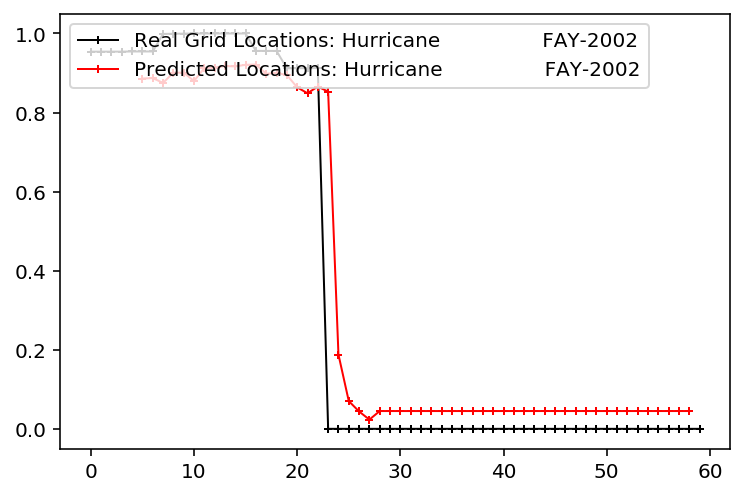

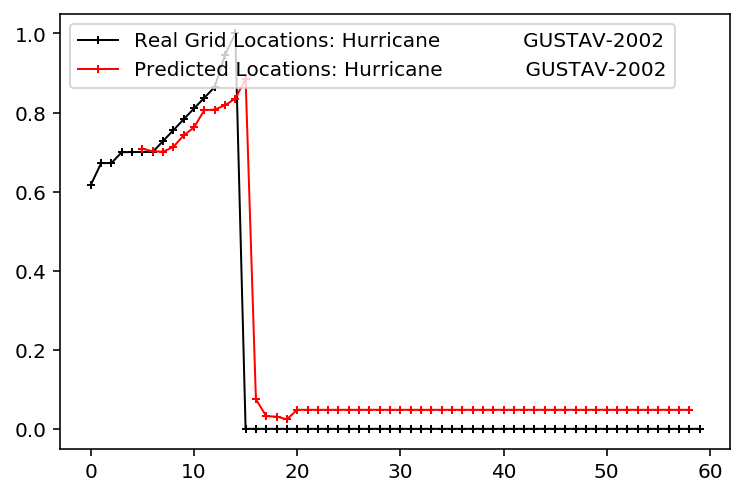

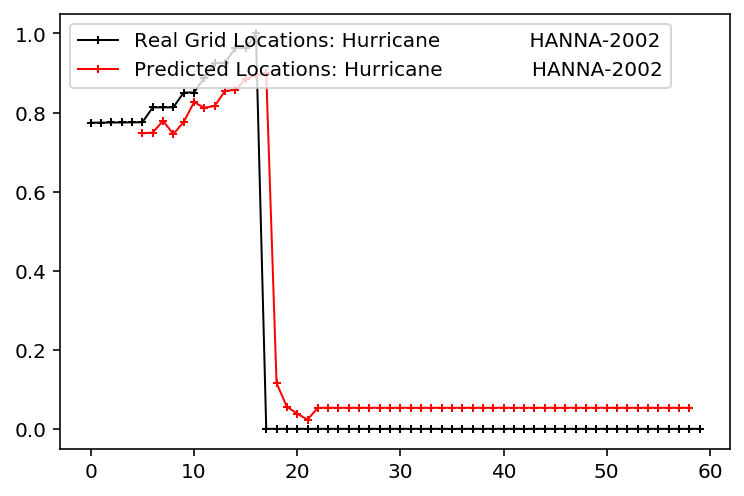

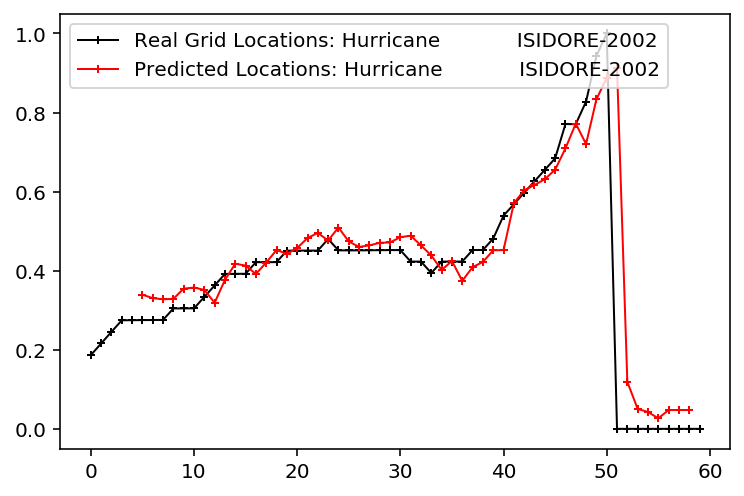

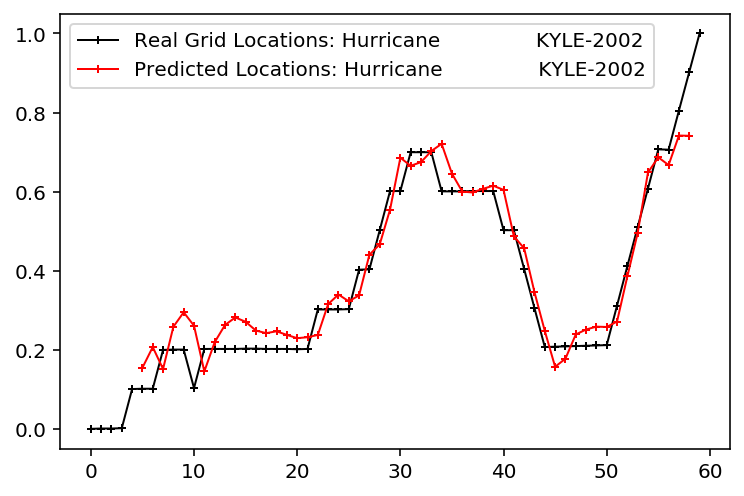

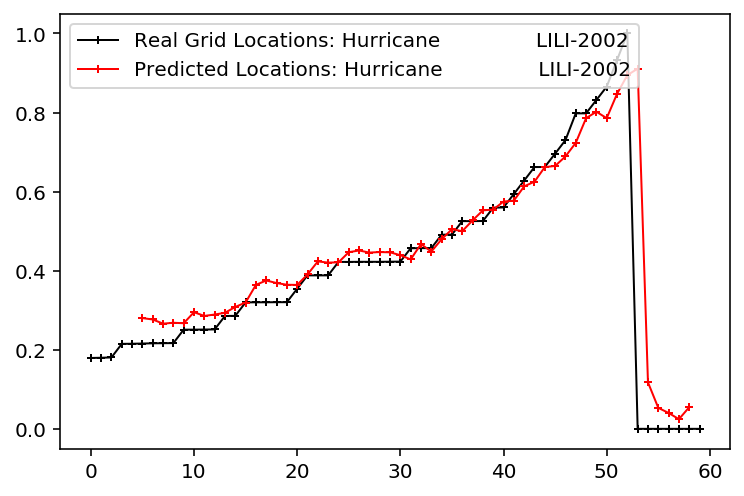

In [72]:
import warnings
warnings.filterwarnings('ignore')

from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error
import math

data = pd.read_csv('points_with_gridIds.csv', index_col=0, header=0)

years = ['2002']

names = [v for i, v in enumerate(data['unique-key'].unique()) if any(s in v for s in years)]

for x in names:

    name = x # Hurricane Key

    window = 5
    if len(data[data['unique-key'] == name]) < 10:
        continue
    try:
        hurricane = prep_hurricane(data[data['unique-key'] == name], name) # This is good

        hurr_data = load_hurricane(hurricane, window)
    except IndexError:
        continue
    hurricane_temp = hurricane['gridID']
   

    pred = model.predict(hurr_data)
    hurricane_temp = hurricane_temp
    
    y = hurricane_temp
    plt.plot(list(np.arange(0,len(y),1)), y,
             linewidth=1, 
             color='black',
             marker='+',
             markersize=4,
             label='Real Grid Locations: Hurricane' + name)
    plt.plot(list(np.arange(5,len(pred) + 5,1)), pred,
         linewidth=1, 
         color='red',
         marker='+',
         markersize=4,
         label='Predicted Locations: Hurricane' + name)
    plt.legend(loc='upper left')

    plt.show()

In [74]:
def grid2coord(grid):
    y = np.floor(grid/long_interval) #y_coord
    x = np.floor(grid-y*long_interval) #x_coord
    return (x+0.5+lon_min, y+0.5+lat_min)

KeyError: 'ALBERTO-1982'

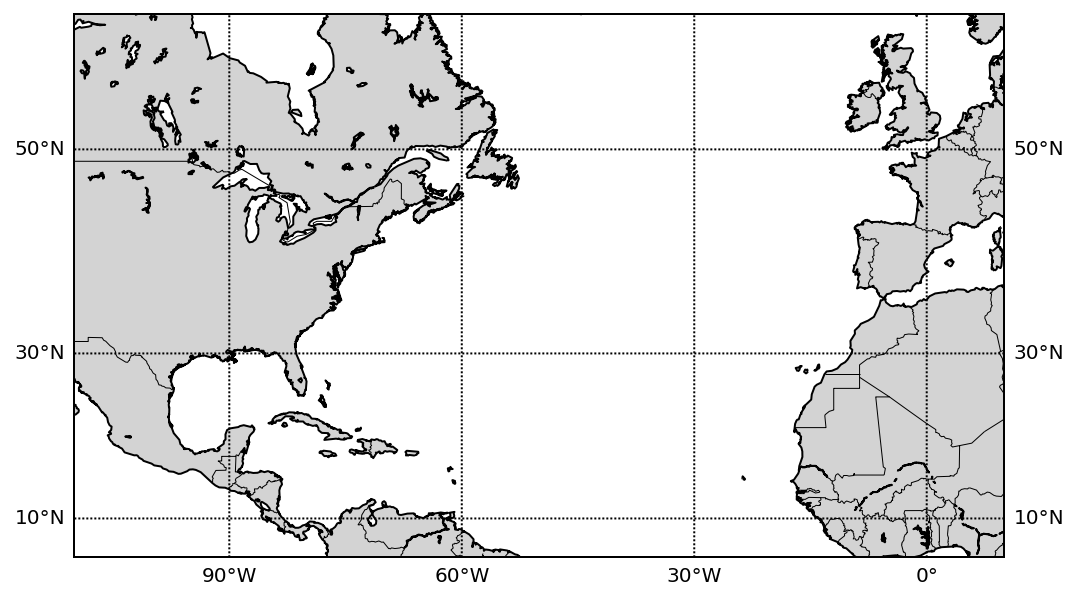

In [78]:
window = 5

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
data = pd.read_csv('points_with_gridIds.csv', index_col=0, header=0)
for x in data['unique-key'].unique():
    if len(data[data['unique-key'] == x]) < 10:
         continue
    hurricane = prep_hurricane(data[data['unique-key'] == x], x)
    hurr_data = load_hurricane(hurricane, window)

    plt.figure(figsize=(10,5))
    m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
                 rsphere=(6378137.00,6356752.3142),
                 resolution='l',
                 projection='merc',
                 lat_0=40.,lon_0=-20.,lat_ts=20.)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='white')
    m.fillcontinents(color='#D3D3D3')
    m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

    hurricane_temp = hurricane['gridID']
    hurricane_temp = hurricane_temp.values.reshape(-1, 1)

    pred = model.predict(hurr_data)
    x = x.strip()
    back2grid = gridScalers[x].inverse_transform(pred)
    lon, lat = grid2coord(back2grid)
    xpt, ypt = m(lon, lat)
    
     #### TESTING INCODING
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % ('predicted value',x.split('-')[1]))
    m.scatter(xpt, ypt, linewidth=2, color='#C70039')

    hurr = data[data['unique-key'] == x]
    lat = hurr['Lat'].values
    long = hurr['Lon'].values

    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (x.split('-')[0],x.split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

# #     plt.savefig('predicted_trajectories')
    plt.show()